In [1]:
using Statistics, Distributions
using SpecialFunctions, LinearAlgebra
import Base.Iterators: product
import Clustering: kmeans
import PyPlot

using Random: seed!

In [2]:
include("./src/Misc.jl")
include("./src/BayesianCausality.jl")
include("./src/Datasets.jl")

using .Misc
import .Datasets
import .BayesianCausality: v_bayes

## Trying the new library functions

In [3]:
function make_param(R::Int, M::Int; γᵣ, m₁ᵣ, m₂ᵣ, λ₁ᵣ, λ₂ᵣ, a₁ᵣ, a₂ᵣ, b₁ᵣ, b₂ᵣ)
    return  Dict(:γ=>fill(γᵣ,R), :m₁=>zeros(R), :m₂=>zeros(R,M), :Λ₁=>fill(λ₁ᵣ,R), 
        :Λ₂=>zeros(R,M,M) .+ λ₂ᵣ*reshape(diagm(0 => ones(M)),1,M,M), :a₁=>fill(a₁ᵣ,R), 
        :a₂=>fill(a₂ᵣ,R), :b₁=>fill(b₁ᵣ,R), :b₂=>fill(b₂ᵣ,R));
end

make_param (generic function with 1 method)

## Functions

In [4]:
mutable struct Particle{ℜ <: Real}
    r::Array{Int,1}
    Σ_R::Array{ℜ,1}
    Σ_Xₙ::Array{ℜ,2}
    Σ_Xₙ²::Array{ℜ,2}

    function Particle(X::Array{ℜ,2}, R::Int; N::Int=1) where {ℜ <: Real}
        T, N = size(X)
        return new{ℜ}(zeros(Int,T), zeros(ℜ,R), zeros(ℜ,R,N), zeros(ℜ,R,N))
    end
    
    function Particle(r::Array{Int,1}, Σ_R::Array{Int,1}, Σ_Xₙ::Array{ℜ,2}, Σ_Xₙ²::Array{ℜ,2}) where {ℜ <: Real}
        return new{ℜ}(copy(r), copy(Σ_R), copy(Σ_Xₙ), copy(Σ_Xₙ²))
    end
    
    function Particle(p::Particle{ℜ}) where {ℜ <: Real}
        return new{ℜ}(copy(p.r), copy(p.Σ_R), copy(p.Σ_Xₙ), copy(p.Σ_Xₙ²))
    end 
end

In [5]:
function naive_bayes(X::Array{ℜ,2}, R::Ƶ=1; γ::Array{ℜ,1}, m::Array{ℜ,2}, Λ::Array{ℜ,2}, 
        a::Array{ℜ,2}, b::Array{ℜ,2}, EPOCHS=1) where {ℜ<:Real, Ƶ<:Integer}
    T, N = size(X)
    ELBO = zeros(EPOCHS)
    
    p = Particle(X, R; N=N)
    p.r .=  T < R ? [1:T...] : R > 1 ? kmeans(Array(X'),R).assignments : ones(Int,T)
    
    x, γʰ = zeros(1,N), zeros(R)
    Λʰ, mʰ = zeros(R,N), zeros(R,N)
    aʰ, bʰ = zeros(R,N), zeros(R,N)
    
    log_q, q = zeros(R), zeros(R)
    ρ, log_ρ, log_θ = zeros(R,N), zeros(R,N), zeros(R)
    
    for (t,r) ∈ enumerate(p.r)
        p.Σ_R[r] += 1.0
        p.Σ_Xₙ[r,:] .+= X[t,:]
        p.Σ_Xₙ²[r,:] .+= X[t,:] .* X[t,:]
    end
    
    for eph ∈ 1:EPOCHS
        γʰ .= γ .+ p.Σ_R
        Λʰ .= Λ .+ p.Σ_R
        mʰ .= (Λ .* m .+ p.Σ_Xₙ) ./ Λʰ
        aʰ .= a .+ p.Σ_R ./ 2
        bʰ .= b .+ (p.Σ_Xₙ² .- mʰ .* Λʰ.* mʰ .+ m .* Λ .* m) ./ 2
        
        log_ρ .= digamma.(aʰ) .- log.(bʰ)
        ρ .= aʰ ./ bʰ
        log_θ .= digamma.(γʰ) .- digamma(sum(γ)+T)
        
        ELBO[eph] += (γ .- γʰ)'*log_θ
        ELBO[eph] += lgamma(sum(γ)) - sum(lgamma,γ)
        ELBO[eph] -= lgamma(sum(γ)+T) - sum(lgamma,γʰ)
        ELBO[eph] += sum(a .* log.(b)) - sum(aʰ .* log.(bʰ))
        ELBO[eph] += sum(lgamma,aʰ) - sum(lgamma,a)
        ELBO[eph] += (sum(log,Λ) - sum(log,Λʰ))/2
        ELBO[eph] += sum(1.0 .- Λ ./ Λʰ)/2
        ELBO[eph] += sum((a .- aʰ) .* log_ρ) - sum((b .- bʰ) .* ρ)
        ELBO[eph] -= sum(ρ .* Λ .* (mʰ .- m).^2)/2
        
        p.Σ_R .= 0.0
        p.Σ_Xₙ .= 0.0
        p.Σ_Xₙ² .= 0.0
        
        for t ∈ 1:T
            x[:] .= X[t,:]
            
            log_q .= log_θ 
            log_q .+= sum(log_ρ .- ρ .* (x .- mʰ).^2 .- 1.0 ./ Λʰ,2)./2
            log_q .-= logsumexp(log_q)
            q .= exp.(log_q)
                            
            p.Σ_R .+= q
            p.Σ_Xₙ .+= q * x[:]'
            p.Σ_Xₙ² .+= q * (x .* x)[:]'
                
            ELBO[eph] += q'*(log_θ .- log_q)
            ELBO[eph] += sum(q'*(log_ρ .- ρ .* (x .- mʰ).^2 .- 1.0 ./ Λʰ))/2

            p.r[t] = argmax(log_q)
        end
                
        ELBO[eph] -= T*log(2π)
        if eph > 1 && ELBO[eph] - ELBO[eph-1] < 1e-6
            ELBO = ELBO[1:eph]
            break
        end
    end
    return ELBO, p.r
end

naive_bayes (generic function with 2 methods)

# Thyroid

In [6]:
C = Int.(Datasets.load("Thyroid",[:class])[:])
X = Datasets.load("Thyroid",[2:6...])

Xⁿ = X .- mean(X;dims=1)
Xⁿ = Xⁿ ./ std(Xⁿ;dims=1);

In [7]:
T, N = size(Xⁿ)

Λᵣ, γᵣ = 0.1, 10.
mᵣ, aᵣ, bᵣ = 0., 1., 1.

(0.0, 1.0, 1.0)

In [8]:
Rs = 1:10
ELBOs = fill(-Inf,length(Rs))

for (r,R) ∈ enumerate(Rs)
    param_naive = Dict(:γ=>fill(γᵣ,R), :m=>fill(mᵣ,R,N), 
        :Λ=>fill(Λᵣ,R,N), :a=>fill(aᵣ,R,N), :b=>fill(bᵣ,R,N))
    for rpt ∈ 1:20
        ELBOs[r] = max(ELBOs[r],naive_bayes(Xⁿ,R; param_naive...,EPOCHS=100)[1][end])
    end
end

┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = #naive_bayes#6(::Array{Float64,1}, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,2}, ::Int64, ::Function, ::Array{Float64,2}, ::Int64) at In[5]:34
└ @ Main ./In[5]:34
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = mapreduce_first at reduce.jl:295 [inlined]
└ @ Core ./reduce.jl:295
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = #naive_bayes#6(::Array{Float64,1}, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,2}, ::Int64, ::Function, ::Array{Float64,2}, ::Int64) at In[5]:35
└ @ Main ./In[5]:35
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = _mapreduce(::typeof(lgamma), ::typeof(Base.add_sum), ::IndexLinear, ::Array{Float64,2}) at reduce.jl:311
└ @ Base ./reduce.jl:311
┌ Warning: `lgamma(x::Real)` is deprecat

In [23]:
print("\$\\mathcal{B_P}[\\mathcal{Q}]\$")

$\mathcal{B_P}[\mathcal{Q}]$

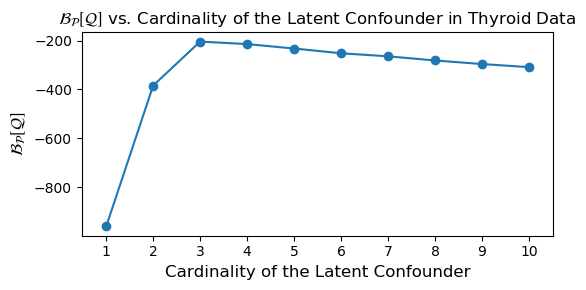

In [64]:
PyPlot.figure(figsize=(6,3))
PyPlot.ylabel("\$\\mathcal{B}_\\mathcal{P}\\mathcal{[Q]}\$")
PyPlot.xlabel("Cardinality of the Latent Confounder")
PyPlot.title("\$\\mathcal{B}_\\mathcal{P}\\mathcal{[Q]}\$ vs. Cardinality of the Latent Confounder in Thyroid Data")
PyPlot.xticks(1:10)
PyPlot.rc("font", size=10)
PyPlot.rc("axes", labelsize=12)
PyPlot.scatter(Rs,ELBOs)
PyPlot.plot(Rs,ELBOs)
PyPlot.tight_layout()
PyPlot.savefig("img/thy.pdf", format="pdf", bbox_to_anchor="tight")

In [10]:
R = 3
param_naive = Dict(:γ=>fill(γᵣ,R), :m=>fill(mᵣ,R,N), 
        :Λ=>fill(Λᵣ,R,N), :a=>fill(aᵣ,R,N), :b=>fill(bᵣ,R,N))
    
ELBO, Cʰ = naive_bayes(Xⁿ,R; param_naive...,EPOCHS=100)

([-418.662, -404.055, -398.222, -397.867, -397.795, -397.768, -397.758, -397.755, -397.754, -397.754, -397.753, -397.753, -397.753, -397.753, -397.753, -397.753, -397.753, -397.753], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  3, 2, 2, 2, 3, 3, 2, 1, 2, 1])

In [11]:
conf = cooccurrences([C Cʰ])
c = conf[:,[2,3,1]]

3×3 Array{Int64,2}:
  0   1  149
  0   0   35
 16  10    4

In [12]:
sum(diag(c))/sum(c)

0.018604651162790697